# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Embedding, Bidirectional, LSTM, Dense,Dropout, BatchNormalization, SpatialDropout1D , Input)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
print("imported libraries successfully")


imported libraries successfully


In [2]:
# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


[nltk_data] Error loading stopwords: <urlopen error [WinError 10051] A
[nltk_data]     socket operation was attempted to an unreachable
[nltk_data]     network>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


# Explore data

In [10]:
df= pd.read_csv('E:/fake-news-detector/data/raw/WELFake_Dataset.csv')

In [11]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [12]:
print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:\n{df['label'].value_counts()}")

Dataset shape: (72134, 4)

Class distribution:
label
1    37106
0    35028
Name: count, dtype: int64


In [13]:
df['label']=df['label'].map({0:1 , 1:0})

In [14]:
df.drop('Unnamed: 0' , axis=1 , inplace=True)


In [18]:
df.head(100)

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,0
1,NaN,Did they post their votes for Hillary already?,0
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",0
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,1
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",0
...,...,...,...
95,Trump THREATENS Comey Via Twitter In His Most...,Donald Trump has some very scary authoritarian...,0
96,Lithuania gets minority government as junior p...,VILNIUS (Reuters) - Lithuania s government los...,1
97,Boiler Room EP #124 – Weather Warfare & CNN Go...,Tune in to the Alternate Current Radio Network...,0
98,COLLEGE REPUBLICANS PRESIDENT Attacked by Anti...,So much for trying to come together like the l...,0


# Text preprocessing

In [19]:
def preprocess_text(text):
    """
    Text preprocessing function 
    This function removes urls , html tags , special characters and extra white spaces and performs lemmetization
    
    """
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'Reuters|http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    
    return ' '.join(words)



In [20]:
# Apply preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)


KeyboardInterrupt: 

In [40]:
df.head()

,title,text,label,cleaned_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,comment expected barack obama member fyf fukyo...
1,NaN,Did they post their votes for Hillary already?,1,post vote hillary already
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,demonstrator gathered last night exercising co...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,dozen politically active pastor came private d...
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,sarmat missile dubbed satan replace fly mile p...


In [41]:

# Remove empty texts after preprocessing
df = df[df['cleaned_text'].str.len() > 0].reset_index(drop=True)

In [42]:
print("clenaed df shape" , df.shape)

clenaed df shape (71211, 4)


# Prepare data for training

In [43]:
voc_size=10000
max_len=300
embedding_dim=200

In [44]:
x= df['cleaned_text']
y = df['label']
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
# Validation split
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [45]:
print("Training set size :" , len(x_train))
print("Validation set size :" , len(x_val))
print("Test set size :" , len(x_test))

Training set size : 49847
Validation set size : 10682
Test set size : 10682


# Tokenization

In [46]:
tokenizer= Tokenizer(num_words=voc_size , oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)

# Convert text to sequences

In [47]:
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Padding

In [48]:
xtrain_pad= pad_sequences(x_train_seq , maxlen=max_len , padding='post', truncating ='post')
xval_pad= pad_sequences(x_val_seq , maxlen=max_len , padding='post', truncating ='post')
xtest_pad= pad_sequences(x_test_seq , maxlen=max_len , padding='post', truncating ='post')

# Training Bi-LSTM model

In [49]:
# Embedding layer
model= keras.Sequential()
model.add(Input(shape=(max_len, )))
model.add(Embedding(input_dim=max_len ,output_dim=embedding_dim,mask_zero=True))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(128 ,return_sequences=True , dropout=0.3, recurrent_dropout=0 , kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64 , dropout=0.3, recurrent_dropout=0 , kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dense(64 , activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32 , activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
print("done")

done


In [50]:
optimizer=keras.optimizers.Adam(learning_rate=0.001)



In [51]:
model.compile(optimizer=optimizer ,
             loss='binary_crossentropy',
             metrics=['accuracy', 
                     keras.metrics.Precision(name='precision'),
                     keras.metrics.Recall(name='recall'),
                     keras.metrics.AUC(name='auc'),
                     ])

In [52]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 300, 200)       │        60,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 300, 200)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 300, 256)       │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 300, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 573,153 (2.19 MB)

 Trainable params: 572,385 (2.18 MB)

 Non-trainable params: 768 (3.00 KB)

# Callbacks

In [53]:
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Save best model
    ModelCheckpoint(
        'best_bilstm_model.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

In [54]:
history= model.fit(xtrain_pad , y_train, batch_size=64, epochs=30 ,validation_data=(xval_pad , y_val), callbacks=callbacks , verbose=1 )

Epoch 1/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8166 - auc: 0.8934 - loss: 3.5783 - precision: 0.7953 - recall: 0.8597
Epoch 1: val_auc improved from -inf to 0.95813, saving model to best_bilstm_model.keras
779/779 ━━━━━━━━━━━━━━━━━━━━ 62s 72ms/step - accuracy: 0.8167 - auc: 0.8934 - loss: 3.5756 - precision: 0.7953 - recall: 0.8598 - val_accuracy: 0.8846 - val_auc: 0.9581 - val_loss: 0.3284 - val_precision: 0.8436 - val_recall: 0.9488 - learning_rate: 0.0010
Epoch 2/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8709 - auc: 0.9460 - loss: 0.4171 - precision: 0.8452 - recall: 0.9131
Epoch 2: val_auc did not improve from 0.95813
779/779 ━━━━━━━━━━━━━━━━━━━━ 54s 70ms/step - accuracy: 0.8709 - auc: 0.9460 - loss: 0.4171 - precision: 0.8452 - recall: 0.9131 - val_accuracy: 0.8716 - val_auc: 0.9552 - val_loss: 0.4314 - val_precision: 0.8133 - val_recall: 0.9698 - learning_rate: 0.0010
Epoch 3/30
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8879 - au

# visualize training history

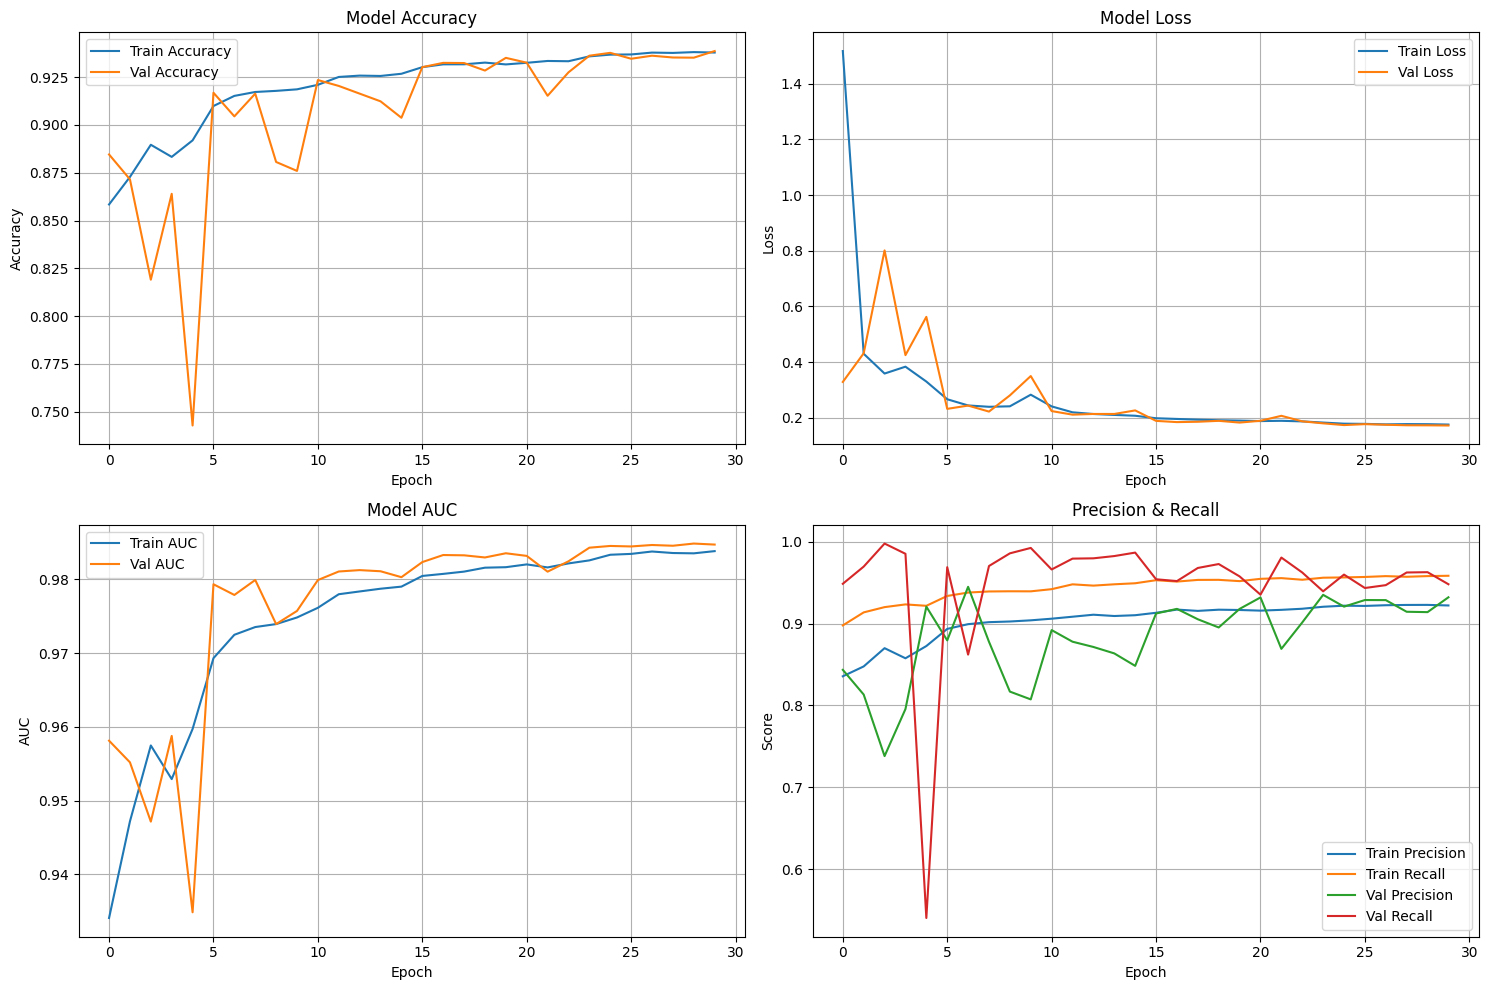

In [56]:
fig ,axes= plt.subplots(2,2 , figsize=(15,10))

#Accuracy
# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss')
axes[0, 1].plot(history.history['val_loss'], label='Val Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# AUC
axes[1, 0].plot(history.history['auc'], label='Train AUC')
axes[1, 0].plot(history.history['val_auc'], label='Val AUC')
axes[1, 0].set_title('Model AUC')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Precision & Recall
axes[1, 1].plot(history.history['precision'], label='Train Precision')
axes[1, 1].plot(history.history['recall'], label='Train Recall')
axes[1, 1].plot(history.history['val_precision'], label='Val Precision')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
axes[1, 1].set_title('Precision & Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True)
    
plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [61]:
# Predictions
y_pred_proba =model.predict(xtest_pad)
y_pred = (y_pred_proba > 0.5).astype(int)

# Classification report
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, 
                            target_names=['Real', 'Fake'],
                            digits=4))

334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        Real     0.9430    0.9189    0.9308      5254
        Fake     0.9234    0.9462    0.9347      5428

    accuracy                         0.9328     10682
   macro avg     0.9332    0.9326    0.9327     10682
weighted avg     0.9330    0.9328    0.9328     10682



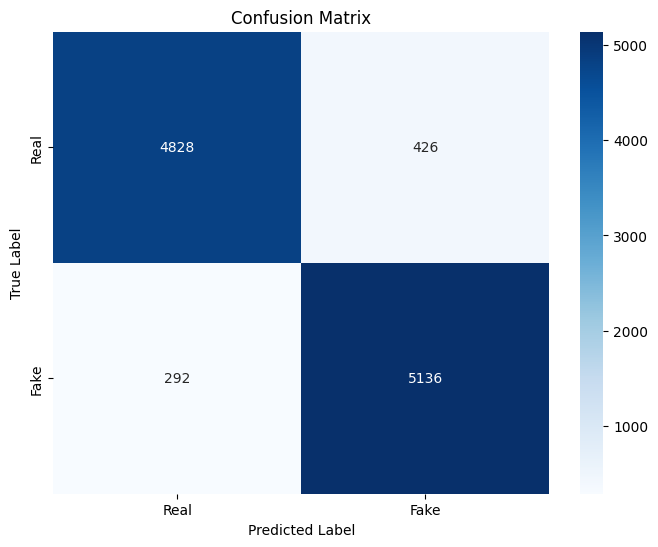

In [63]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
    

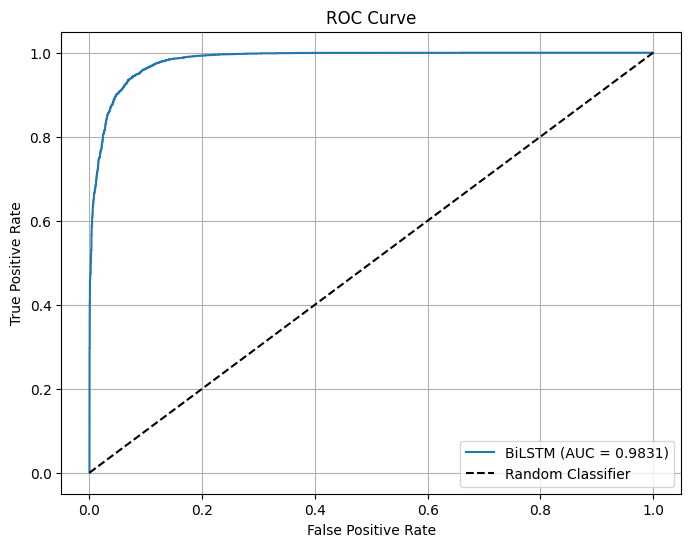

In [64]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'BiLSTM (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [65]:
# Save the model
model.save('fake_news_bilstm_final.keras')

# Save tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("\n=== MODEL SAVED ===")
print("Model saved as: fake_news_bilstm_final.keras")
print("Tokenizer saved as: tokenizer.pkl")


=== MODEL SAVED ===
Model saved as: fake_news_bilstm_final.keras
Tokenizer saved as: tokenizer.pkl


In [ ]:
# def predict_news(text, model, tokenizer, max_len=MAX_LEN):
#     """
#     Predict whether a news article is fake or real
#     """
#     # Preprocess
#     cleaned_text = preprocess_text(text)
    
#     # Tokenize and pad
#     sequence = tokenizer.texts_to_sequences([cleaned_text])
#     padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    
#     # Predict
#     prediction = model.predict(padded, verbose=0)[0][0]
    
#     label = "FAKE" if prediction > 0.5 else "REAL"
#     confidence = prediction if prediction > 0.5 else 1 - prediction
    
#     return {
#         'label': label,
#         'confidence': confidence,
#         'probability': prediction
#     }

# Example usage:
# sample_text = "Your news article text here..."
# result = predict_news(sample_text, model, tokenizer)
# print(f"\nPrediction: {result['label']}")
# print(f"Confidence: {result['confidence']:.2%}")